## Uncertainty quantification of tranmission coefficients with KDUQ and UQ'ed mass models
Mass models enter the calculation of transmission coefficients in the kinematics of the projectile-target system, and in the Fermi energy of the target, which in the Koning-Delaroche is parameterized (perhaps too) simply as a linear function of $A$. This implies that the Fermi energies fit to stable isotopes  will be reasonable, but effects due to asymmetry $(N-Z)/A$, for example, will not be encapsulated, which may be important off the line of stability. In particular, for example, one would expect neutron-rich isotopes to have smaller neutron Fermi, indicating valence neutrons are much closer to the continuum in such systems.

In this notebook, we will propagate KDUQ uncertainties into transmission coefficients using regular old KDUQ, and, for comparison, using a KDUQ with an uncertainty quantified mass model to predict the Fermi energies instead of the simple paramteric form in KDUQ. Transmission coefficients are relevant observables because they important for compound-nuclear processes like $(n,\gamma)$ reactions, which are important in very neutron-rich nuclei for r-process nucleosynthesis.

In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import Latex, Math, display
from periodictable import elements

from jitr.utils import mass

In [2]:
def neutron_fermi_energy_KD(A, Z):
    return -11.2814 + 0.02646 * A


def proton_fermi_energy_KD(A, Z):
    return -8.4075 + 0.01378 * A

## Compare models to KD

In [3]:
A, Z = (154, 56)

In [4]:
name_core = str(elements[Z].symbol)
display(Math(f"^{{{A}}} \\rm{{{name_core}}}"))

<IPython.core.display.Math object>

In [5]:
for m in mass.__MASS_MODELS__:
    Ef = mass.neutron_fermi_energy(A, Z, model=m)
    print(f"{m:7}: {Ef[0]:1.4f} +/- {Ef[1]}")

BMA    : -3.6700 +/- 2.928163874630591
ws4rbf : -3.4174 +/- nan
UNEDF2 : -3.5264 +/- nan
dz31   : -3.4939 +/- nan
UNEDF1 : -3.4964 +/- nan
HFB24  : -3.7864 +/- nan
SVMIN  : -3.6514 +/- nan
SKM    : -4.1414 +/- nan
UNEDF0 : -3.6114 +/- nan
hfb31  : -3.6514 +/- nan
D1M    : -3.6014 +/- nan
SLY4   : -3.4264 +/- nan
SKP    : -3.6264 +/- nan
ame2020: nan +/- nan
BCPM   : -3.6764 +/- nan
FRDM2012: -3.5514 +/- nan


In [6]:
neutron_fermi_energy_KD(A, Z)

-7.20656

In [7]:
for m in mass.__MASS_MODELS__:
    Ef = mass.proton_fermi_energy(A, Z, model=m)
    print(f"{m:7}: {Ef[0]:1.4f} +/- {Ef[1]}")

BMA    : -13.1027 +/- 2.8786616888136276
ws4rbf : -13.8941 +/- nan
UNEDF2 : -13.6486 +/- nan
dz31   : -13.5521 +/- nan
UNEDF1 : -13.7586 +/- nan
HFB24  : -13.2636 +/- nan
SVMIN  : -13.4186 +/- nan
SKM    : -12.5986 +/- nan
UNEDF0 : -13.3486 +/- nan
hfb31  : -12.6936 +/- nan
D1M    : -13.6836 +/- nan
SLY4   : -13.8936 +/- nan
SKP    : -13.1386 +/- nan
ame2020: nan +/- nan
BCPM   : -13.2686 +/- nan
FRDM2012: -13.5936 +/- nan


In [8]:
proton_fermi_energy_KD(A, Z)

-6.28538

## Transmission coefficients
Let's use `jitr` to calculate UQ'ed transmission coefficients using KDUQ Fermi energies and those from a variety of mass models

In [9]:
from tqdm import tqdm

import jitr

In [10]:
A, Z = (154, 56)
neutron = (1, 0)
target = (A, Z)

In [12]:
# we have 416 samples from the KDUQ posterior
num_samples_kduq = 415
param_files = [
    Path(jitr.data_dir / f"KDUQFederal/{i}/parameters.json").absolute()
    for i in range(0, num_samples_kduq)
]

# load each one
kduq_omp_samples = [
    jitr.optical_potentials.kduq.Global(neutron, Path(param_file))
    for param_file in param_files
]

In [13]:
# com_energy_grid = np.logspace(-1, 1.3, 100)
com_energy_grid = np.linspace(0.01, 5, 200)
core_solver = jitr.rmatrix.Solver(50)
range_fm = jitr.utils.interaction_range(A)
lmax = 4
print(range_fm)

6.432130093158435


In [14]:
reaction = jitr.reactions.Reaction(target=target, projectile=neutron, process="EL")

In [15]:
def set_up_grid(core, com_energy_grid, mass_model="BMA"):
    solvers = []
    mn = jitr.utils.constants.MASS_N
    mcore = jitr.utils.mass.mass(*core, model=mass_model)[0]
    for i, Ecm in enumerate(tqdm(com_energy_grid)):
        kinematics = jitr.utils.kinematics.classical_kinematics_cm(mcore, mn, Ecm)

        a = range_fm * kinematics.k + np.pi / 2
        N = jitr.utils.suggested_basis_size(a)
        assert N < core_solver.kernel.quadrature.nbasis

        solvers.append(
            jitr.xs.elastic.IntegralWorkspace(
                reaction=reaction,
                kinematics=kinematics,
                channel_radius_fm=a / kinematics.k,
                solver=core_solver,
                lmax=lmax,
                smatrix_abs_tol=0,
            )
        )
    return solvers

In [16]:
solvers = set_up_grid(target, com_energy_grid, mass_model="BMA")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.34it/s]


## Run UQ

In [17]:
N = 400  # number of samples to draw from each posterior
draws_kduq = np.random.choice(len(kduq_omp_samples), size=N)

### KDUQ

In [19]:
tcoeff_kduq = np.zeros((com_energy_grid.size, N, 2, lmax))
for j, sample in enumerate(tqdm(draws_kduq)):
    omp = kduq_omp_samples[sample]

    for i, Ecm in enumerate(com_energy_grid):
        coulomb_params, scalar_params, spin_orbit_params = omp.get_params(
            *target,
            solvers[i].kinematics.Elab,
        )

        tplus, tminus = solvers[i].transmission_coefficients(
            jitr.optical_potentials.kduq.central,
            jitr.optical_potentials.kduq.spin_orbit,
            scalar_params,
            spin_orbit_params,
        )
        tcoeff_kduq[i, j, 0, :] = tplus
        tcoeff_kduq[i, j, 1, :] = tminus

 15%|██████████████████████▍                                                                                                                                 | 59/400 [00:21<01:27,  3.91it/s]/home/beyerk/Projects/jitr/src/jitr/optical_potentials/kduq.py:396: RuntimeWarning: overflow encountered in exp
  d2 = d2_0 + d2_A / (1 + np.exp((A - d2_A3) / d2_A2))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:52<00:00,  3.57it/s]


### KDUQ wth BMA Fermi energies

In [20]:
# set Fermi energy to BMA
Ef = mass.neutron_fermi_energy(A, Z, model="BMA")

In [45]:
tcoeff_kduq_bma = np.zeros((com_energy_grid.size, N, 2, lmax))
for j, sample in enumerate(tqdm(draws_kduq)):
    omp = kduq_omp_samples[sample]

    # reset Ef
    omp.params["Ef_A"] = 0
    omp.params["Ef_0"] = np.random.normal(loc=Ef[0], scale=Ef[1])  # sample from BMA

    for i, Ecm in enumerate(com_energy_grid):

        coulomb_params, scalar_params, spin_orbit_params = omp.get_params(
            *target,
            solvers[i].kinematics.Elab,
        )

        tplus, tminus = solvers[i].transmission_coefficients(
            jitr.optical_potentials.kduq.central,
            jitr.optical_potentials.kduq.spin_orbit,
            scalar_params,
            spin_orbit_params,
        )
        tcoeff_kduq_bma[i, j, 0, :] = tplus
        tcoeff_kduq_bma[i, j, 1, :] = tminus

 15%|██████████████████████▍                                                                                                                                 | 59/400 [00:15<01:37,  3.51it/s]/home/beyerk/Projects/jitr/src/jitr/optical_potentials/kduq.py:396: RuntimeWarning: overflow encountered in exp
  d2 = d2_0 + d2_A / (1 + np.exp((A - d2_A3) / d2_A2))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [01:48<00:00,  3.69it/s]


## Extract confidence intervals

In [46]:
def get_confidence_intervals(tcoeffs):
    ci = []
    for l in range(3):
        ci.append([])
        ci[l].append(
            (
                np.percentile(tcoeffs[:, :, 0, l], 16, axis=1),
                np.percentile(tcoeffs[:, :, 0, l], 84, axis=1),
            )
        )
        if l > 0:
            ci[l].append(
                (
                    np.percentile(tcoeffs[:, :, 1, l], 16, axis=1),
                    np.percentile(tcoeffs[:, :, 1, l], 84, axis=1),
                )
            )
    return ci

In [47]:
kduq_ci = get_confidence_intervals(tcoeff_kduq)
kduq_bma_ci = get_confidence_intervals(tcoeff_kduq_bma)

## Plotting

In [48]:
kduq_color = "tab:blue"
bma_color = "tab:orange"

In [49]:
from matplotlib import pyplot as plt
from matplotlib import rcParams

plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
plt.rc("text", usetex=True)
rcParams["text.latex.preamble"] = (
    r"\usepackage{amssymb} \usepackage{amsmath} \usepackage{braket}"
)

(0.0, 5.0)

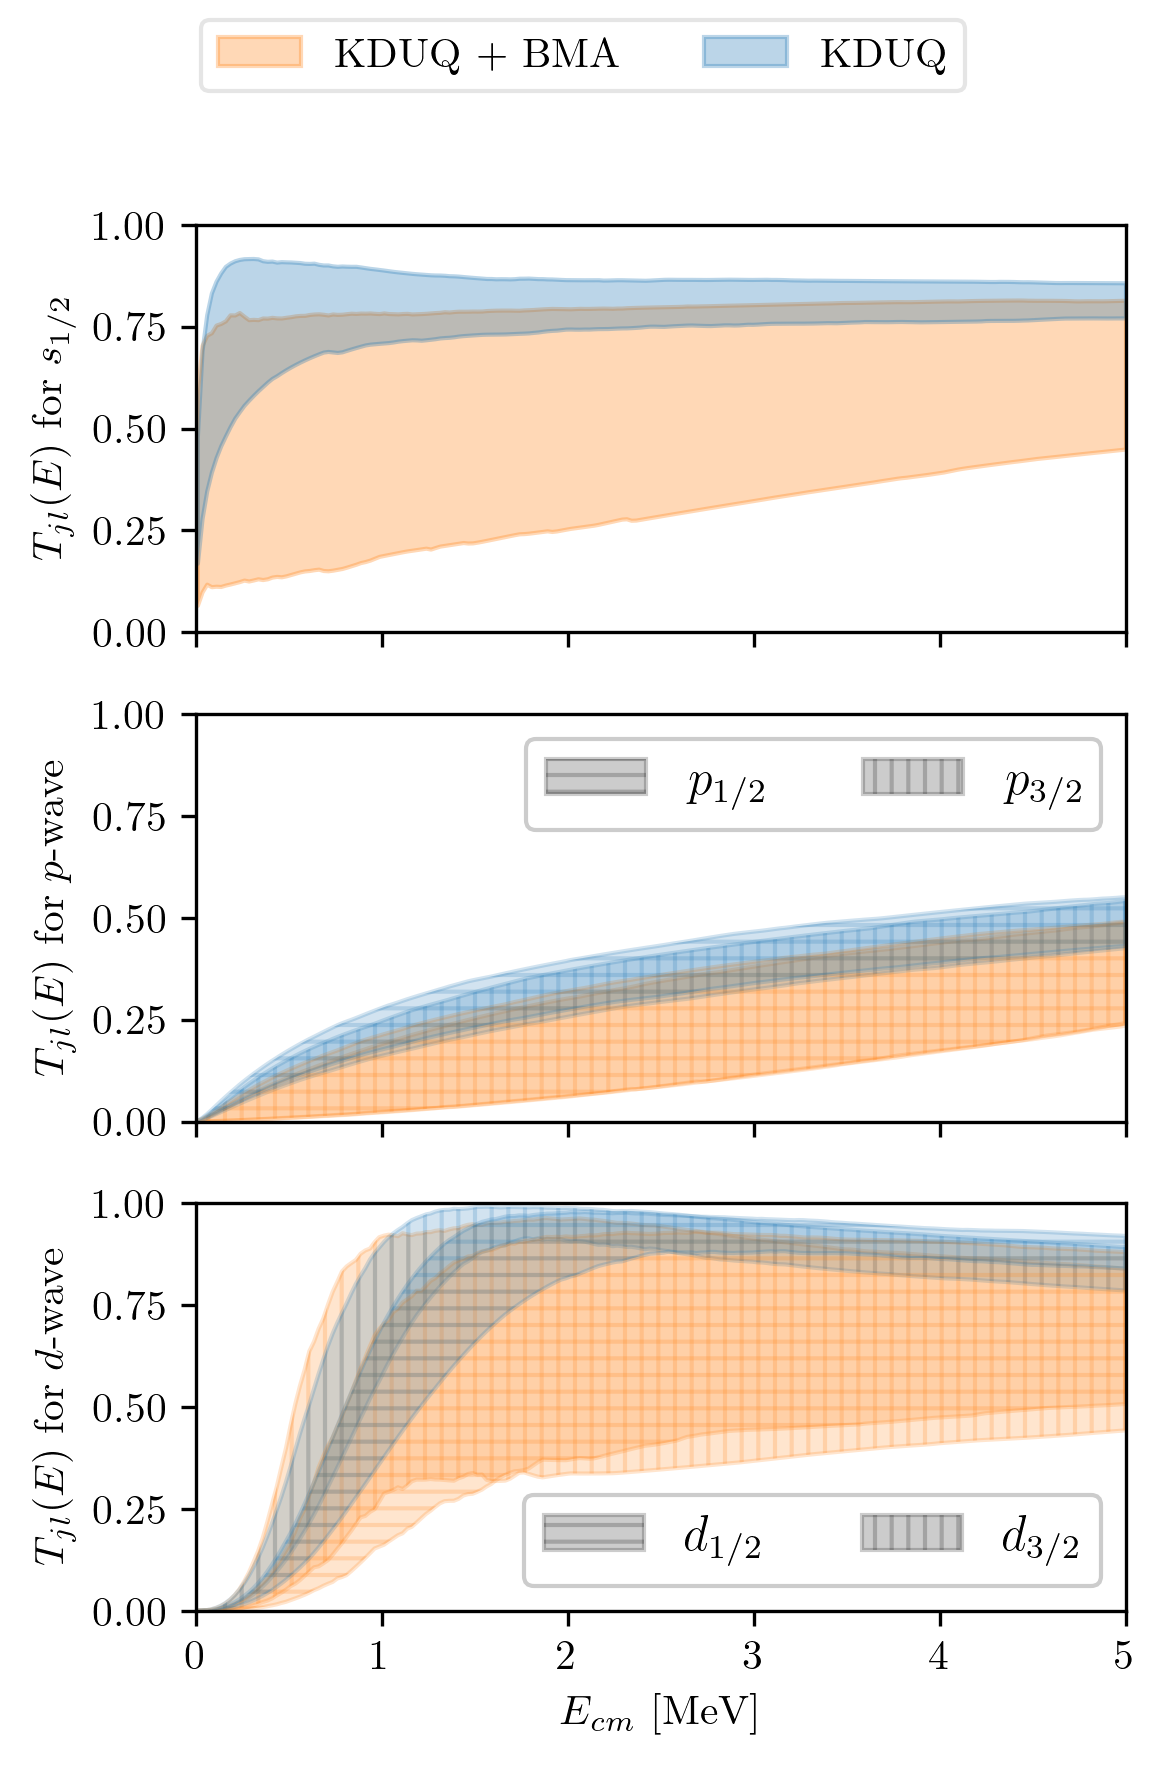

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(
    figsize=(4, 6), nrows=3, ncols=1, dpi=300, sharex=True
)

ax1.fill_between(
    com_energy_grid,
    kduq_bma_ci[0][0][0],
    kduq_bma_ci[0][0][1],
    color=bma_color,
    alpha=0.3,
    label="KDUQ + BMA",
)
ax1.fill_between(
    com_energy_grid,
    kduq_ci[0][0][0],
    kduq_ci[0][0][1],
    color=kduq_color,
    alpha=0.3,
    label="KDUQ",
)

ax2.fill_between(
    com_energy_grid,
    kduq_bma_ci[1][0][0],
    kduq_bma_ci[1][0][1],
    color=bma_color,
    alpha=0.2,
    hatch="|||",
)
ax2.fill_between(
    com_energy_grid,
    kduq_ci[1][0][0],
    kduq_ci[1][0][1],
    color=kduq_color,
    alpha=0.2,
    hatch="|||",
)
ax2.fill_between(
    com_energy_grid,
    kduq_bma_ci[1][1][0],
    kduq_bma_ci[1][1][1],
    color=bma_color,
    alpha=0.2,
    hatch="---",
)
ax2.fill_between(
    com_energy_grid,
    kduq_ci[1][1][0],
    kduq_ci[1][1][1],
    color=kduq_color,
    alpha=0.2,
    hatch="---",
)

ax3.fill_between(
    com_energy_grid,
    kduq_bma_ci[2][0][0],
    kduq_bma_ci[2][0][1],
    color=bma_color,
    alpha=0.2,
    hatch="|||",
)
ax3.fill_between(
    com_energy_grid,
    kduq_ci[2][0][0],
    kduq_ci[2][0][1],
    color=kduq_color,
    alpha=0.2,
    hatch="|||",
)
ax3.fill_between(
    com_energy_grid,
    kduq_bma_ci[2][1][0],
    kduq_bma_ci[2][1][1],
    color=bma_color,
    alpha=0.2,
    hatch="---",
)
ax3.fill_between(
    com_energy_grid,
    kduq_ci[2][1][0],
    kduq_ci[2][1][1],
    color=kduq_color,
    alpha=0.2,
    hatch="---",
)

# style legend
swave_style = [
    ax3.fill_between(
        [-1, 0],
        [-1, 0],
        [-1, 0],
        color="k",
        alpha=0.2,
    ),
]
lwave_style = [
    ax3.fill_between(
        [-1, 0],
        [-1, 0],
        [-1, 0],
        color="k",
        alpha=0.2,
        hatch="---",
    ),
    ax3.fill_between(
        [-1, 0],
        [-1, 0],
        [-1, 0],
        color="k",
        alpha=0.2,
        hatch="|||",
    ),
]


style_legend2 = ax2.legend(
    lwave_style,
    [r"$p_{1/2}$", r"$p_{3/2}$"],
    ncols=2,
    # loc="upper  right",
    fontsize=12,
    framealpha=1,
)
style_legend3 = ax3.legend(
    lwave_style,
    [r"$d_{1/2}$", r"$d_{3/2}$"],
    ncols=2,
    loc="lower right",
    fontsize=12,
    framealpha=1,
)
fig.legend(loc="upper center", ncols=2, framealpha=0.5)

ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])
ax3.set_ylim([0, 1])

ax1.set_ylabel(r"$T_{jl}(E)$ for $s_{1/2}$")
ax2.set_ylabel(r"$T_{jl}(E)$ for $p$-wave")
ax3.set_ylabel(r"$T_{jl}(E)$ for $d$-wave")

plt.xlabel(r"$E_{cm}$ [MeV]")
plt.xlim([0, 5])